In [ ]:
import numpy as np
from collections import Counter

In [ ]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [ ]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=15):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.
        
        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.
        
        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
    
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

In [ ]:
def Level_Order_Traversal(root):
  traversed = []
  traversed.append(root)
  count = 0
  if root is None:
    return traversed
  while traversed != []:
    count += 1
    x = traversed.pop(0) 
    if x.data_left:
      traversed.append(x.data_left)
    if x.data_right:
      traversed.append(x.data_right)
  print(count)

In [ ]:
dataset = pd.read_csv('D1.txt', header=None, delimiter=' ').to_numpy()

X = dataset[:, 0:-1]
Y = dataset[:, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]
clf = DecisionTree()
clf.fit(X, Y)

In [ ]:
Level_Order_Traversal(clf.root)

3


[]

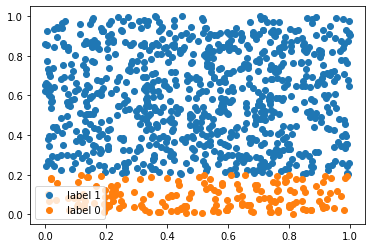

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dataset_D1 = pd.read_csv('D1.txt', header=None, delimiter=' ').to_numpy()
dataset_D2 = pd.read_csv('D2.txt', header=None, delimiter=' ').to_numpy()

X_D1_label_1 = dataset_D1[dataset_D1[:,-1]==1]
Y_D1_label_0 = dataset_D1[dataset_D1[:,-1]==0]


# X_D1 = dataset_D1[:, 0:-1]
# Y_D1 = dataset_D1[:, -1]

# X_D2 = dataset_D2[:, 0:-1]
# Y_D2 = dataset_D2[:, -1]

fig, ax = plt.subplots()
ax.scatter(X_D1_label_1[:,0], X_D1_label_1[:,1], label='label 1')
ax.scatter(Y_D1_label_0[:,0], Y_D1_label_0[:,1], label='label 0')

ax.legend()
plt.plot()

[]

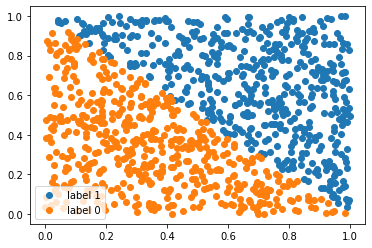

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dataset_D2 = pd.read_csv('D2.txt', header=None, delimiter=' ').to_numpy()

X_D2_label_1 = dataset_D2[dataset_D2[:,-1]==1]
Y_D2_label_0 = dataset_D2[dataset_D2[:,-1]==0]


# X_D1 = dataset_D1[:, 0:-1]
# Y_D1 = dataset_D1[:, -1]

# X_D2 = dataset_D2[:, 0:-1]
# Y_D2 = dataset_D2[:, -1]

fig, ax = plt.subplots()
ax.scatter(X_D2_label_1[:,0], X_D2_label_1[:,1], label='label 1')
ax.scatter(Y_D2_label_0[:,0], Y_D2_label_0[:,1], label='label 0')

ax.legend()
plt.plot()

[]

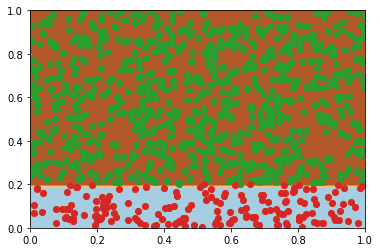

In [ ]:
import pandas as pd
import pdb

dataset = pd.read_csv('D1.txt', header=None, delimiter=' ').to_numpy()

X = dataset[:, 0:-1]
Y = dataset[:, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]
clf = DecisionTree()
clf.fit(X, Y)

# Plot the decision boundary
n_classes = 2
plot_colors = "br"
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = 0 , 1.01
y_min, y_max = 0 , 1.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])
# Plot the training points

X_D1_label_1 = dataset_D1[dataset_D1[:,-1]==1]
Y_D1_label_0 = dataset_D1[dataset_D1[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_D1_label_1[:,0], X_D1_label_1[:,1],
                cmap=plt.cm.Paired)
    plt.scatter(Y_D1_label_0[:,0], Y_D1_label_0[:,1],
                cmap=plt.cm.Paired)

plt.axis("tight")
plt.plot()

[]

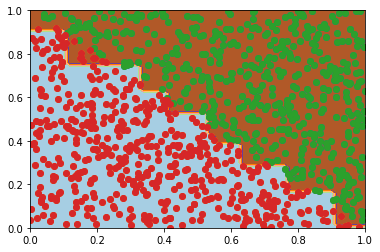

In [ ]:
from sklearn import tree
import pandas as pd

dataset = pd.read_csv('D2.txt', header=None, delimiter=' ').to_numpy()

X = dataset[:, 0:-1]
Y = dataset[:, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]
clf = DecisionTree()
clf.fit(X, Y)


# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = 0 , 1.01
y_min, y_max = 0 , 1.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_D2_label_1 = dataset_D2[dataset_D2[:,-1]==1]
Y_D2_label_0 = dataset_D2[dataset_D2[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_D2_label_1[:,0], X_D2_label_1[:,1],
                cmap=plt.cm.Paired)
    plt.scatter(Y_D2_label_0[:,0], Y_D2_label_0[:,1],
                cmap=plt.cm.Paired)

plt.axis("tight")
plt.plot()

node count:
199
err: 0.014380530973451378


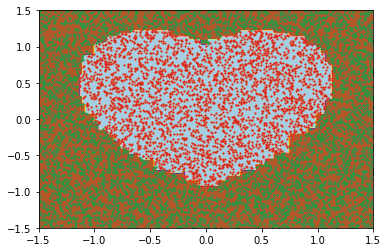

In [ ]:
from sklearn import tree
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Dbig.txt', header=None, delimiter=' ').to_numpy()

second_size = 8192/10000

X_test, X_train = train_test_split(dataset, test_size=second_size, random_state=2)

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = DecisionTree()
clf.fit(X_train[:,:-1], X_train[:,-1])
# n_nodes = clf.tree_.node_count
print('node count:')
Level_Order_Traversal(clf.root)
# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=1)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=1)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

node count:
113
err: 0.030684104627766606


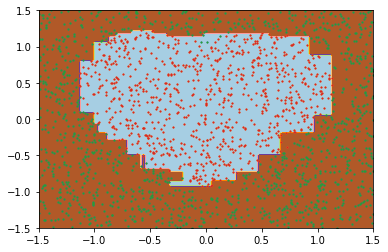

In [ ]:
from sklearn import tree
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Dbig.txt', header=None, delimiter=' ').to_numpy()

second_size = 2048/10000

X_test, X_train = train_test_split(dataset, test_size=second_size, random_state=2)

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = DecisionTree()
clf.fit(X_train[:,:-1], X_train[:,-1])
# n_nodes = clf.tree_.node_count
print('node count:')
Level_Order_Traversal(clf.root)
# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=1)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=1)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

node count:
51
err: 0.05143338954468801


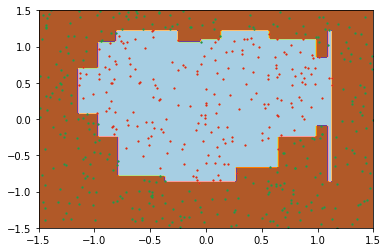

In [ ]:
from sklearn import tree
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Dbig.txt', header=None, delimiter=' ').to_numpy()

second_size = 512/10000

X_test, X_train = train_test_split(dataset, test_size=second_size, random_state=2)

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = DecisionTree()
clf.fit(X_train[:,:-1], X_train[:,-1])
# n_nodes = clf.tree_.node_count
print('node count:')
Level_Order_Traversal(clf.root)
# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=1)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=1)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

node count:
33
err: 0.10656401944894656


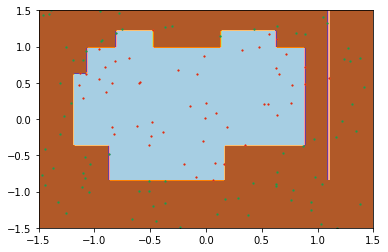

In [ ]:
from sklearn import tree
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Dbig.txt', header=None, delimiter=' ').to_numpy()

second_size = 128/10000

X_test, X_train = train_test_split(dataset, test_size=second_size, random_state=2)

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = DecisionTree()
clf.fit(X_train[:,:-1], X_train[:,-1])
# n_nodes = clf.tree_.node_count
print('node count:')
Level_Order_Traversal(clf.root)
# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=1)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=1)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

node count:
5
err: 0.2289325842696629


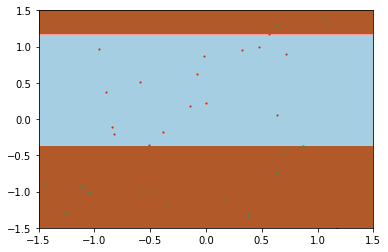

In [ ]:
from sklearn import tree
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Dbig.txt', header=None, delimiter=' ').to_numpy()

second_size = 32/10000

X_test, X_train = train_test_split(dataset, test_size=second_size, random_state=2)

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = DecisionTree()
clf.fit(X_train[:,:-1], X_train[:,-1])
# n_nodes = clf.tree_.node_count
print('node count:')
Level_Order_Traversal(clf.root)
# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=1)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=1)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

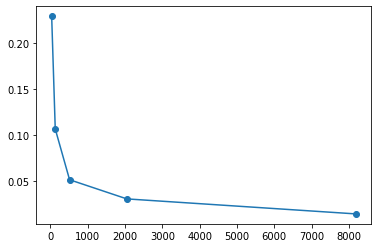

In [101]:
plt.plot([32,128,512,2048,8192], [0.2289, 0.1065,0.0514,0.0306,0.0143], marker='o')

node count:
199
err: 0.009955752212389424


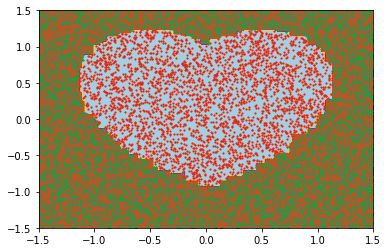

In [ ]:
from sklearn import tree
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Dbig.txt', header=None, delimiter=' ').to_numpy()

second_size = 8192/10000

X_test, X_train = train_test_split(dataset, test_size=second_size, random_state=2)

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train[:,:-1], X_train[:,-1])
n_nodes = clf.tree_.node_count
print('node count:')
print(n_nodes)
# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=1)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=1)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

node count:
113
err: 0.01603982300884954


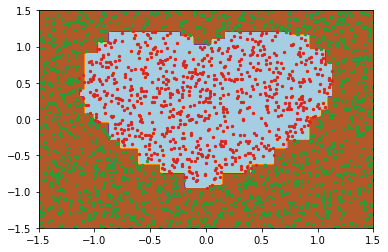

In [ ]:
second_size = 2048/10000
X_test_XXX, X_train = train_test_split(dataset, test_size=second_size)
# X_train = X_train[0:2048,:]
# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train[:,:-1], X_train[:,-1])
n_nodes = clf.tree_.node_count
print('node count:')
print(n_nodes)

# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=5)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=5)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

node count:
39
err: 0.042588495575221264


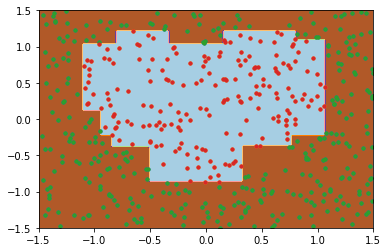

In [ ]:
second_size = 512/10000
X_test_XXX, X_train = train_test_split(dataset, test_size=second_size)

# X_train = X_train[0:512,:]

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train[:,:-1], X_train[:,-1])
n_nodes = clf.tree_.node_count
print('node count:')
print(n_nodes)

# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=10)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=10)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

node count:
19
err: 0.07190265486725667


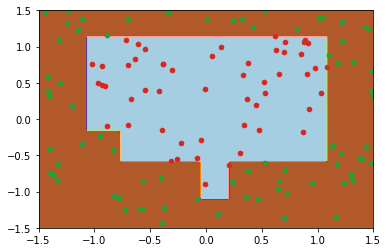

In [ ]:
# X_train = X_train[0:128,:]

second_size = 128/10000
X_test_XXX, X_train = train_test_split(dataset, test_size=second_size)

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train[:,:-1], X_train[:,-1])
n_nodes = clf.tree_.node_count
print('node count:')
print(n_nodes)

# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired, s=20)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired, s=20)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

node count:
9
err: 0.1924778761061947


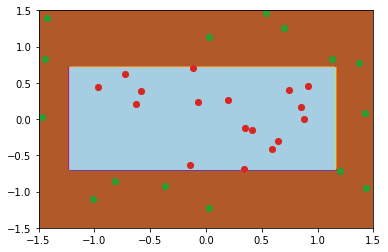

In [ ]:
# X_train = X_train[0:32,:]

second_size = 32/10000
X_test_XXX, X_train = train_test_split(dataset, test_size=second_size)

# np.random.seed(0)
# rng = default_rng()
# seleted_idx = rng.choice(9999, size=8192, replace=False)

# X = dataset[seleted_idx, 0:-1]
# Y = dataset[seleted_idx, -1]
# X = [[10, 1], [10, 2], [10, 3], [1, 1], [1, 3]]
# Y = [1, 1, 1, 0, 1]

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train[:,:-1], X_train[:,-1])
n_nodes = clf.tree_.node_count
print('node count:')
print(n_nodes)

# Plot the decision boundary
plot_step = 0.02

fig, ax = plt.subplots()
x_min, x_max = -1.5 , 1.51
y_min, y_max = -1.5 , 1.51
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
# plt.xlabel(iris.feature_names[pair[0]])
# plt.ylabel(iris.feature_names[pair[1]])

X_Dbig_label_1 = X_train[X_train[:,-1]==1]
Y_Dbig_label_0 = X_train[X_train[:,-1]==0]
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(Y == i)
    plt.scatter(X_Dbig_label_1[:,0], X_Dbig_label_1[:,1],
                cmap=plt.cm.Paired)
    plt.scatter(Y_Dbig_label_0[:,0], Y_Dbig_label_0[:,1],
                cmap=plt.cm.Paired)

plt.axis("tight")
plt.plot()

y_pred = clf.predict(X_test[:,:-1])
print("err:",1 - metrics.accuracy_score(X_test[:,-1], y_pred))

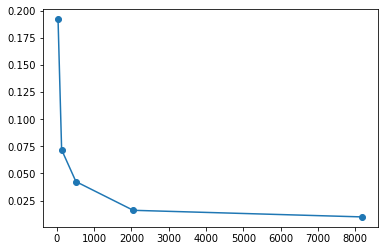

In [100]:
plt.plot([32,128,512,2048,8192], [0.1924,0.0719,0.0425,0.0160,0.0099], marker='o')

In [102]:
import numpy as np
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt
np.random.seed(0)
x_data = np.random.uniform(-np.pi,np.pi,100)
x_train_all = x_data[0:50]
x_train_all.sort()
x_test = x_data[50:100]
x_test.sort()
y_test = np.sin(x_test)


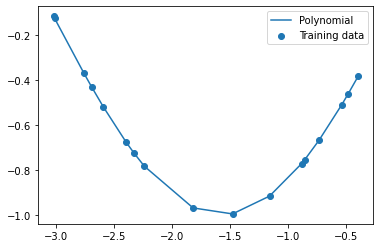

Mean squared error: 2.3587771650769354e-07


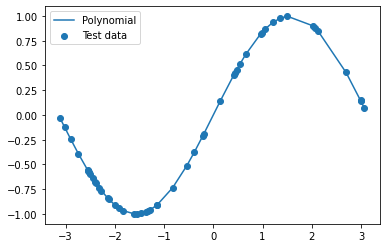

Mean squared error: 1.7038199586645423e-06


In [103]:
x_train = x_train_all[:17]
y_train = np.sin(x_train)

poly = lagrange(x_train, y_train)
plt.scatter(x_train, y_train, label='Training data')
plt.plot(x_train, Polynomial(poly.coef[::-1])(x_train), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_train - Polynomial(poly.coef[::-1])(x_train)).sum() / x_train.shape[0]
print('Mean squared error:', error)

plt.scatter(x_test, y_test, label='Test data')
plt.plot(x_test, Polynomial(poly.coef[::-1])(x_test), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_test - Polynomial(poly.coef[::-1])(x_test)).sum() / x_test.shape[0]
print('Mean squared error:', error)

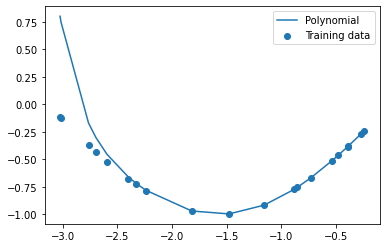

Mean squared error: 0.0832201739440797


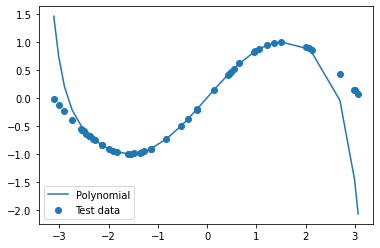

Mean squared error: 0.26377341678094934


In [105]:
x_train = x_train_all[:20]
y_train = np.sin(x_train)

poly = lagrange(x_train, y_train)
plt.scatter(x_train, y_train, label='Training data')
plt.plot(x_train, Polynomial(poly.coef[::-1])(x_train), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_train - Polynomial(poly.coef[::-1])(x_train)).sum() / x_train.shape[0]
print('Mean squared error:', error)

plt.scatter(x_test, y_test, label='Test data')
plt.plot(x_test, Polynomial(poly.coef[::-1])(x_test), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_test - Polynomial(poly.coef[::-1])(x_test)).sum() / x_test.shape[0]
print('Mean squared error:', error)

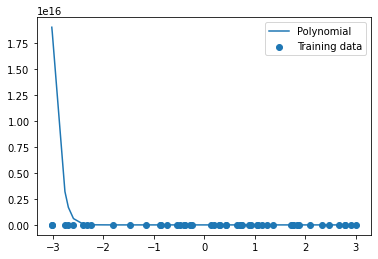

Mean squared error: 1.4344214218904724e+31


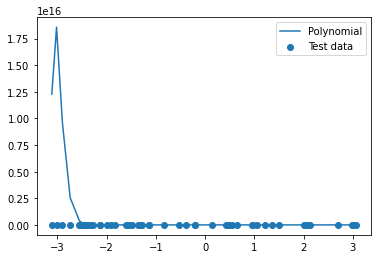

Mean squared error: 1.1870981875182768e+31


In [106]:
x_train = x_train_all[:50]
y_train = np.sin(x_train)

poly = lagrange(x_train, y_train)
plt.scatter(x_train, y_train, label='Training data')
plt.plot(x_train, Polynomial(poly.coef[::-1])(x_train), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_train - Polynomial(poly.coef[::-1])(x_train)).sum() / x_train.shape[0]
print('Mean squared error:', error)

plt.scatter(x_test, y_test, label='Test data')
plt.plot(x_test, Polynomial(poly.coef[::-1])(x_test), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_test - Polynomial(poly.coef[::-1])(x_test)).sum() / x_test.shape[0]
print('Mean squared error:', error)

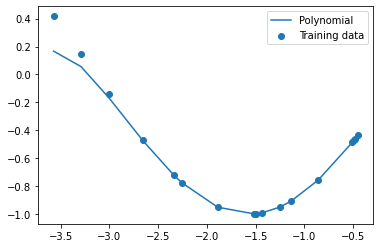

Mean squared error: 0.004242920339257745


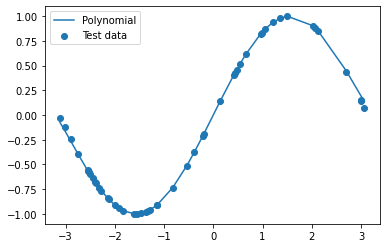

Mean squared error: 0.0002630158313295854


In [107]:
np.random.seed(0)
x_data = np.random.uniform(-np.pi,np.pi,100)
noise = np.random.normal(0,1.0,50)
x_train_all = x_data[0:50] + noise
x_train_all.sort()
x_test = x_data[50:100]
x_test.sort()
y_test = np.sin(x_test)

x_train = x_train_all[:17]
y_train = np.sin(x_train)

poly = lagrange(x_train, y_train)
plt.scatter(x_train, y_train, label='Training data')
plt.plot(x_train, Polynomial(poly.coef[::-1])(x_train), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_train - Polynomial(poly.coef[::-1])(x_train)).sum() / x_train.shape[0]
print('Mean squared error:', error)

plt.scatter(x_test, y_test, label='Test data')
plt.plot(x_test, Polynomial(poly.coef[::-1])(x_test), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_test - Polynomial(poly.coef[::-1])(x_test)).sum() / x_test.shape[0]
print('Mean squared error:', error)

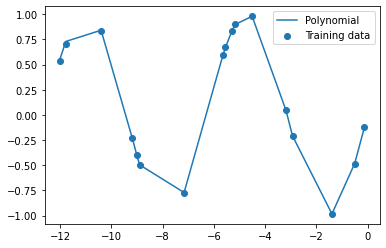

Mean squared error: 8.088339184339026e-05


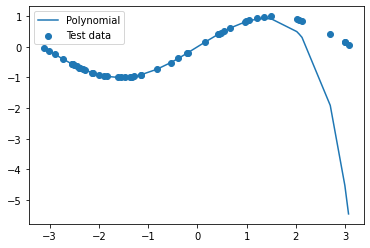

Mean squared error: 1.6110445106658728


In [108]:
np.random.seed(0)
x_data = np.random.uniform(-np.pi,np.pi,100)
noise = np.random.normal(0,8.0,50)
x_train_all = x_data[0:50] + noise
x_train_all.sort()
x_test = x_data[50:100]
x_test.sort()
y_test = np.sin(x_test)

x_train = x_train_all[:17]
y_train = np.sin(x_train)

poly = lagrange(x_train, y_train)
plt.scatter(x_train, y_train, label='Training data')
plt.plot(x_train, Polynomial(poly.coef[::-1])(x_train), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_train - Polynomial(poly.coef[::-1])(x_train)).sum() / x_train.shape[0]
print('Mean squared error:', error)

plt.scatter(x_test, y_test, label='Test data')
plt.plot(x_test, Polynomial(poly.coef[::-1])(x_test), label='Polynomial')
plt.legend()
plt.show()
error = np.square(y_test - Polynomial(poly.coef[::-1])(x_test)).sum() / x_test.shape[0]
print('Mean squared error:', error)